In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pspipe import database, settings

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

%matplotlib inline

In [9]:
def load_ps_data(work_dir, instrument, obs_id):
    """Load dataset and return data + PS generator."""
    rev_file = os.path.join(work_dir, f"default_{instrument}.toml")
    s = settings.Settings.load_with_defaults(rev_file)
    rev = database.VisRevision(s)
    data = rev.get_data(obs_id)
    data.do_flag(None, False, False)
    ps_gen = data.get_ps_gen(ft_method='lssa')
    return data, ps_gen


# -------------------------------------------------------------
#   SINGLE DATASET PLOTS (2D PS + 1D k_par)
# -------------------------------------------------------------
def plot_single_dataset(work_dir, instrument, obs_id, pol="XX", kpar_max=None):
    data, ps_gen = load_ps_data(work_dir, instrument, obs_id)

    try:
        vis = data.get_stokes(pol)
    except:
        raise ValueError(f"Polarisation '{pol}' not available.")

    ps2d = ps_gen.get_ps2d(vis)

    # --- 2D PS ---
    fig, ax = plt.subplots()
    ps2d.plot(ax=ax)
    ax.set_title(f"2D PS ({pol})")
    if kpar_max is not None:
        ax.set_ylim(ymax=kpar_max)

    # --- 1D k_parallel ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ps2d.plot_kpar(ax=ax)
    ax.set_title(f"1D PS vs k∥ ({pol})")
    if kpar_max is not None:
        ax.set_xlim(xmax=kpar_max)

    plt.show()


# -------------------------------------------------------------
#   COMPARE TWO DATASETS (PS of visibility difference)
# -------------------------------------------------------------
def compare_two_datasets(work_dir_1, work_dir_2, instrument, obs_id, pol="XX", kpar_max=None):
    data1, psgen1 = load_ps_data(work_dir_1, instrument, obs_id)
    data2, psgen2 = load_ps_data(work_dir_2, instrument, obs_id)

    try:
        vis1 = data1.get_stokes(pol)
        vis2 = data2.get_stokes(pol)
    except:
        raise ValueError(f"Polarisation '{pol}' not available.")

    # --- PS of each ---
    ps2d_1 = psgen1.get_ps2d(vis1)
    ps2d_2 = psgen2.get_ps2d(vis2)

    # --- PS of visibility-difference ---
    vis_diff = vis2 - vis1
    ps2d_diff = psgen2.get_ps2d(vis_diff)

    # ------------------------------------------------------
    #   FIGURE 1: before, after, diff
    # ------------------------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

    ps2d_1.plot(ax=axs[0])
    axs[0].set_title(f"Before ({pol})")

    ps2d_2.plot(ax=axs[1])
    axs[1].set_title(f"After ({pol})")
    axs[1].set_ylabel("")

    ps2d_diff.plot(ax=axs[2])
    axs[2].set_title(f"PS(After – Before) ({pol})")
    axs[2].set_ylabel("")

    if kpar_max is not None:
        axs[0].set_ylim(ymax=kpar_max)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    #   FIGURE 2: k_par comparison
    # ------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 5))

    ps2d_1.plot_kpar(ax=ax, label="Before")
    ps2d_2.plot_kpar(ax=ax, label="After")
    ps2d_diff.plot_kpar(ax=ax, label="PS(After – Before)", color="C3", lw=1.4)

    if kpar_max is not None:
        ax.set_xlim(xmax=kpar_max)

    ax.set_title(f"1D k∥ ({pol})")
    ax.legend()
    plt.show()


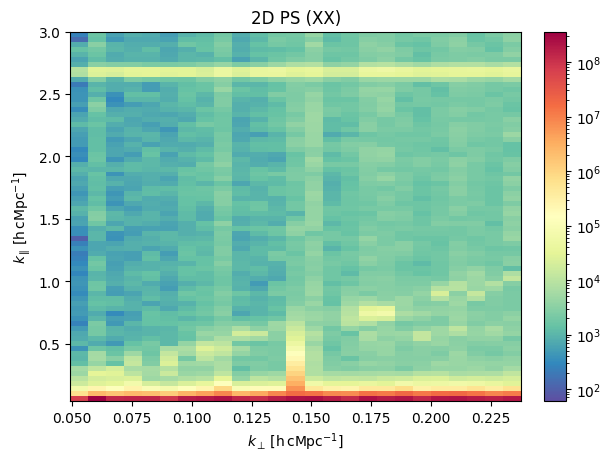

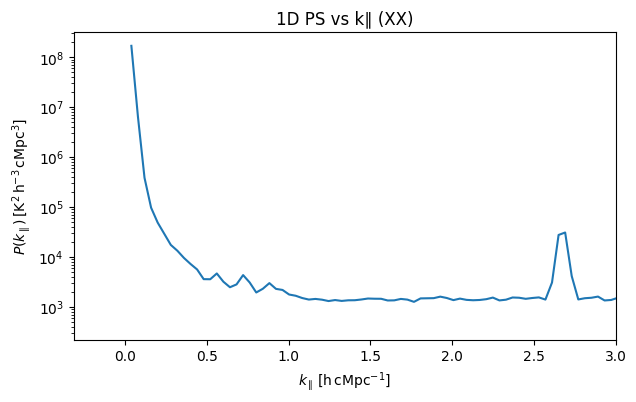

In [15]:
work_dir_before = '/net/node310/data/users/lofareor/mertens/srcnet/dsc-037/pspipe_lofar_bpcorr_3/'
work_dir_after = '/net/node310/data/users/lofareor/mertens/srcnet/dsc-037/pspipe_lofar_bpcorr'
obs_id = 'L253456_SAP000_002_time1.flagged.5ch8s.dical'

plot_single_dataset(work_dir=work_dir_before, instrument="lofar", obs_id=obs_id, kpar_max=3, pol='XX')

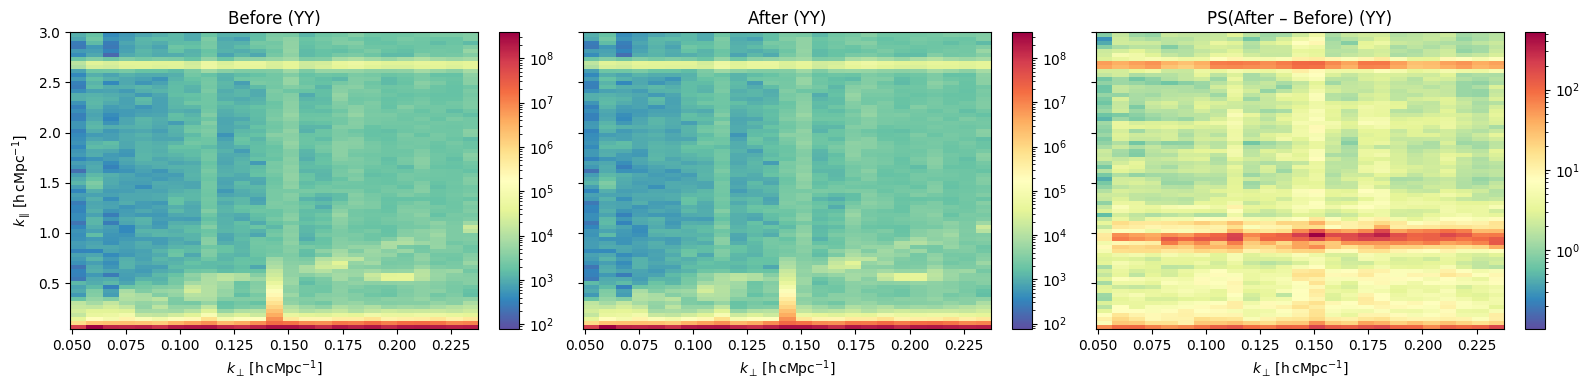

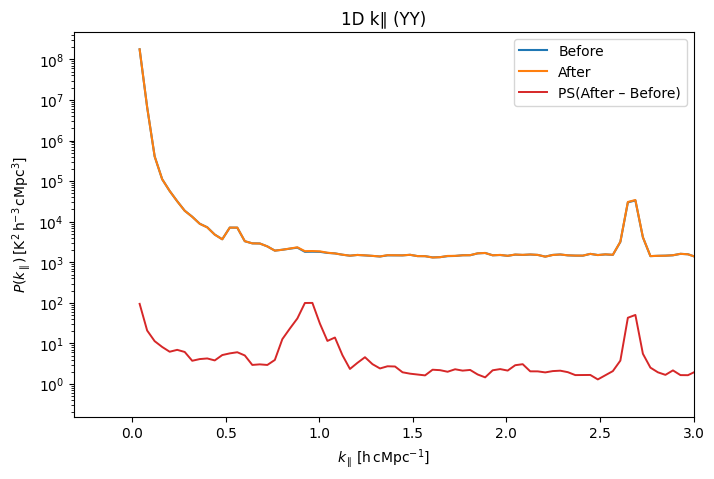

In [11]:
compare_two_datasets(work_dir_before, work_dir_after, 'lofar', obs_id, kpar_max=3, pol='YY')